In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

#plt.ion() # for interactive mode

## 1. Load the data

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
image_folder = '/gdrive/My Drive/Colab Notebooks/padh.ai.notebooks/9. CNN with PyTorch/3. PyTorch Official Tutorial/3. Transfer Learning Tutorial/hymenoptera_data'

image_datasets = {}
image_dataloader = {}

data_transforms = {'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
  ]), 'val': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
  ])
}

for data_type in ['train','val']:
  image_datasets[data_type] = datasets.ImageFolder(os.path.join(image_folder,data_type), transform=data_transforms[data_type])
  image_dataloader[data_type] = torch.utils.data.DataLoader(image_datasets[data_type], shuffle=True, batch_size=4, num_workers=4)
 
classes = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)
print('classes:',classes)

cuda:0
classes: ['ants', 'bees']


torch.Size([4, 3, 224, 224])


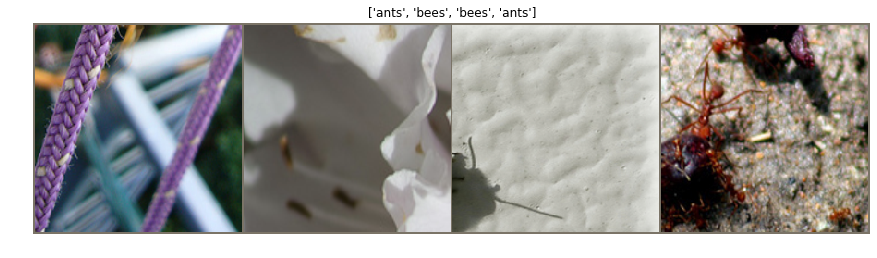

In [0]:
## displaying the images

images, labels = next(iter(image_dataloader['train']))
print(images.size())

def display_image(img, label=None):
  img = img.numpy()
  img = np.transpose(img, (1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.224])
  img = img*std+mean
  img = np.clip(img,0,1)
  plt.figure(figsize=(15,10))
  plt.imshow(img)
  plt.axis('off')
  if label is not None:
    plt.title(label)
  
  
display_image(torchvision.utils.make_grid(images), [classes[x] for x in labels])

## 2. Defining the model

In [0]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
# modifying the last layer to 2 features

model.fc = nn.Linear(model.fc.in_features,2)
print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


In [0]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 3. Training the model

- Scheduling the learning rate
- Saving the best model

In [0]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    for phase in ['train','val']:

      if phase is 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_correct = 0.0
      for images,labels in image_dataloader[phase]:
        
        # feeding the images of batch size = 4

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(images)
          preds = torch.argmax(outputs,dim=1)
          loss = criterion(outputs,labels)
          
          if phase is 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss
        running_correct += torch.sum(preds==labels.data)


      epoch_loss = running_loss/len(image_datasets[phase])
      epoch_acc =  running_correct.double()/len(image_datasets[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
      
    print()
  time_elapsed = time.time() - since
  print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed/60, time_elapsed%60))
  print('Best accuracy: {:.2f}'.format(best_acc))
  
  model.load_state_dict(best_model_wts)
  return model

trained_model = train_model(model, optimizer, criterion, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.1353 Acc: 0.6967
val Loss: 0.0818 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.0993 Acc: 0.8402
val Loss: 0.0634 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.1248 Acc: 0.7951
val Loss: 0.0745 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.1533 Acc: 0.7664
val Loss: 0.1382 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.1132 Acc: 0.8156
val Loss: 0.0814 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.1060 Acc: 0.8320
val Loss: 0.1028 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.0772 Acc: 0.8689
val Loss: 0.0833 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.0651 Acc: 0.8893
val Loss: 0.0665 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.0581 Acc: 0.8975
val Loss: 0.0677 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.0858 Acc: 0.8361
val Loss: 0.0620 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0817 Acc: 0.8607
val Loss: 0.0644 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0866 Acc: 0.8607
val Loss: 0.0657 Acc: 0.9085

Ep

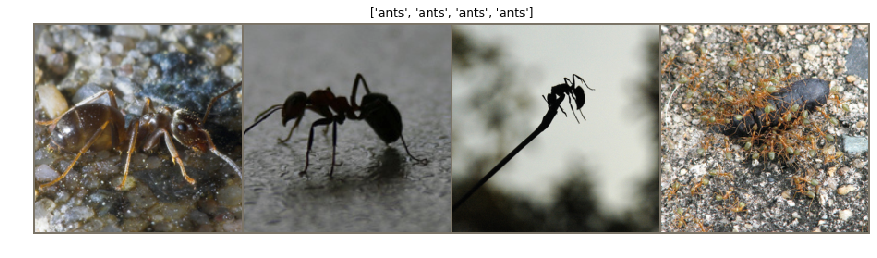

In [0]:
# visualizing the model
def visualize_prediction(model):
  images, labels = next(iter(image_dataloader['val']))
  preds = torch.argmax(model(images.to(device)),dim=1)

  display_image(torchvision.utils.make_grid(images), [classes[x.item()] for x in preds])
  
visualize_prediction(trained_model)

## 4. ConvNet as fixed feature extractor

In [0]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False
  
# Parameters of newly constructed modules have requires_grad=True by default
model_conv.fc = nn.Linear(model_conv.fc.in_features,2)
model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
trained_conv_net = train_model(model_conv, optimizer_conv, criterion, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1658 Acc: 0.6598
val Loss: 0.0609 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.1617 Acc: 0.7131
val Loss: 0.0562 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.1493 Acc: 0.7582
val Loss: 0.0469 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1235 Acc: 0.7869
val Loss: 0.0450 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1163 Acc: 0.7910
val Loss: 0.0681 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.1555 Acc: 0.7336
val Loss: 0.0770 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.0990 Acc: 0.8279
val Loss: 0.0527 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.0787 Acc: 0.8402
val Loss: 0.0563 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0919 Acc: 0.8443
val Loss: 0.0555 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0820 Acc: 0.8730
val Loss: 0.0585 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0750 Acc: 0.8525
val Loss: 0.0517 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0913 Acc: 0.8443
val Loss: 0.0594 Acc: 0.9346

Ep

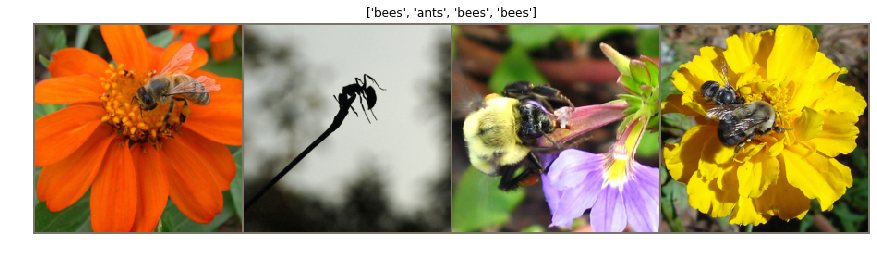

In [0]:
visualize_prediction(trained_conv_net)